## Loading the dataset

In [1]:
import pandas as pd
df = pd.read_csv("./year_week.csv")
df.head()

,production,p_per_m2,p_max,panel_area,facade_area,total_panel_area,exploitation_ratio,air_temp_mean,air_temp_max,clearsky_ghi_mean,...,relative_humidity_max,surface_pressure_mean,surface_pressure_min,surface_pressure_max,wind_direction_100m_mean,wind_direction_100m_min,wind_direction_100m_max,wind_speed_100m_mean,wind_speed_100m_min,wind_speed_100m_max
0,5.200000,143.0,210.0,1.72,218.0,94.6,0.434,2.505230,4.200000,60.951418,...,94.220000,1034.960009,1033.440000,1037.220000,270.313918,194.000000,328.400000,4.257234,1.920000,5.860000
1,1.400000,143.0,210.0,1.72,218.0,94.6,0.434,2.479167,4.000000,60.812500,...,95.900000,1034.843750,1031.700000,1038.100000,259.770833,227.000000,339.000000,5.036170,2.000000,6.200000
2,2.742857,143.0,210.0,1.72,218.0,94.6,0.434,2.639881,3.571429,64.693452,...,92.528571,1025.654167,1022.557143,1028.500000,246.068452,156.428571,311.714286,5.367262,3.328571,7.528571
3,1.200000,143.0,210.0,1.72,218.0,94.6,0.434,2.895833,4.000000,64.312500,...,93.500000,1024.008333,1020.000000,1027.300000,251.979167,213.000000,300.000000,4.456250,2.500000,7.700000
4,14.614286,143.0,210.0,1.72,218.0,94.6,0.434,3.446429,5.857143,71.940476,...,91.314286,1015.603869,1011.585714,1020.142857,210.104167,169.714286,266.285714,5.892857,3.800000,7.757143


## Preoaring the (x,y) pairs

### Scaling the data

In [2]:
from sklearn.preprocessing import MinMaxScaler


scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df.values)

### Creating windows

In [3]:
production_column = 'production'

def get_target_column_index(df, target_column):
    for i, column in enumerate(df.columns):
        if column == target_column:
            return i

    return -1

In [4]:
import numpy as np

def get_windows(data, window_size=10):
    x = []
    y = []

    for i in range(window_size, len(data)):
        x.append(data[i-window_size:i])
        y.append(data[i][get_target_column_index(df, production_column)])

    return np.array(x), np.array(y)

In [5]:
window_size = 2*12  # 2*1h window
x, y = get_windows(data_scaled, window_size=window_size)

x.shape, y.shape

((3150, 24, 34), (3150,))

### Splitting the data

In [6]:
train_split_index = int(0.8 * len(df))
test_split_index = int(0.9 * len(df))

x_train, y_train = x[:train_split_index], y[:train_split_index]
x_test, y_test = x[train_split_index:test_split_index], y[train_split_index:test_split_index]
x_val, y_val = x[test_split_index:], y[test_split_index:]

x_train.shape, y_train.shape, x_test.shape, y_test.shape, x_val.shape, y_val.shape

((2539, 24, 34), (2539,), (317, 24, 34), (317,), (294, 24, 34), (294,))

### Plotting the splits

In [7]:
import matplotlib.pyplot as plt


def plot_time_series(timesteps, values, label, format='-^', start=0, end=None):
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel("date")
    plt.ylabel("production")

    plt.legend(fontsize=14)
    plt.grid(True)

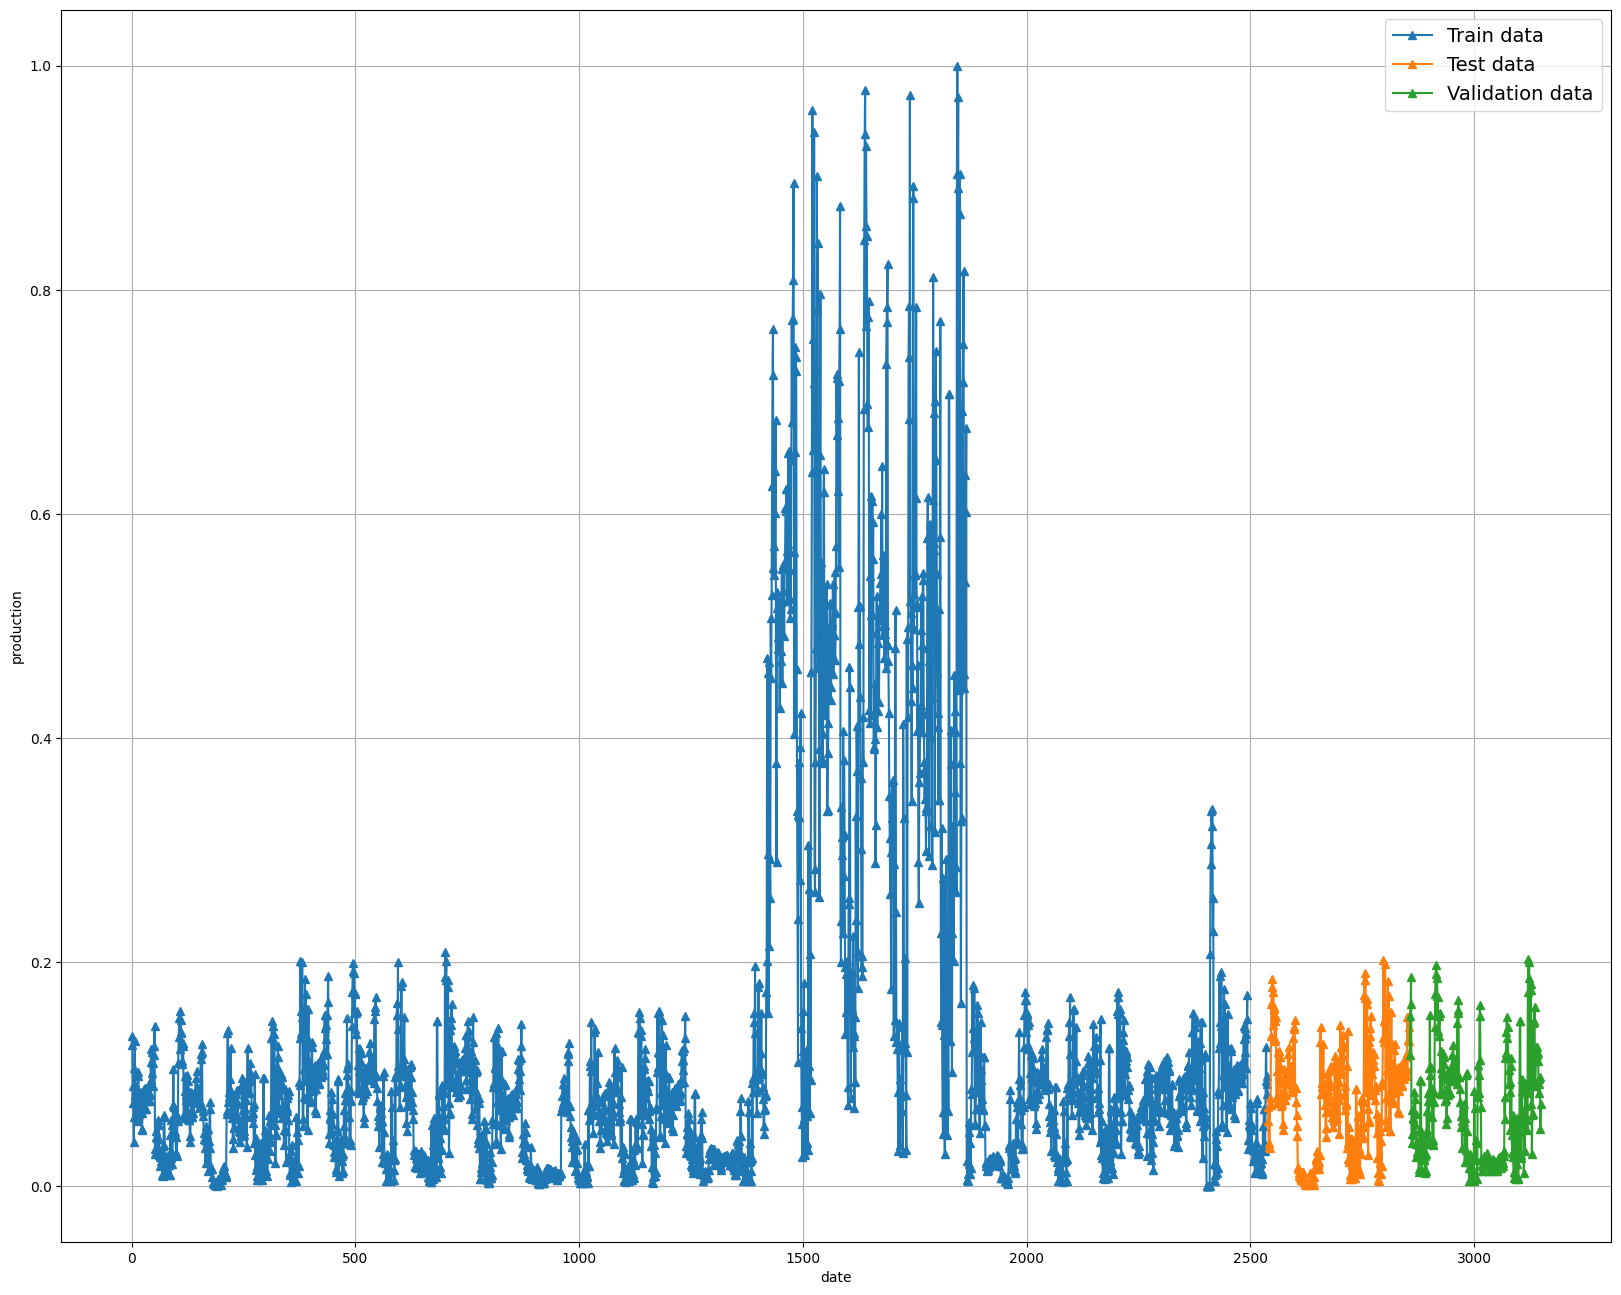

In [8]:
plt.figure(figsize=(20, 16))

timesteps = range(len(x_train))
plot_time_series(timesteps=timesteps, values=y_train, label="Train data")

timesteps = range(len(x_train), len(x_train) + len(x_test))
plot_time_series(timesteps=timesteps, values=y_test, label="Test data")

timesteps = range(len(x_train) + len(x_test),
                  len(x_train) + len(x_test) + len(x_val))
plot_time_series(timesteps=timesteps, values=y_val, label="Validation data")

### Preparing the performances metrics

In [9]:
import tensorflow as tf
from sklearn.metrics import r2_score

In [10]:
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    return {
        'mse': mse,
        'r2': r2,
        'mae': mae,
        'mape': mape,
    }

In [11]:
def evaluate_preds(y_true, y_pred):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)

    mae_metric = tf.keras.metrics.MeanAbsoluteError()
    mse_metric = tf.keras.metrics.MeanSquaredError()

    mae_metric.update_state(y_true, y_pred)
    mse_metric.update_state(y_true, y_pred)

    mae = mae_metric.result().numpy()
    mse = mse_metric.result().numpy()
    r2 = r2_score(y_true.numpy(), y_pred.numpy())  # Assure-toi que y_true et y_pred sont des numpy arrays

    return {
        "mae": mae,
        "mse": mse,
        "r2": r2
    }

## Modeling

In [12]:
import os
import tensorflow as tf

from keras.layers import Dense, Dropout, LSTM, Flatten, ConvLSTM1D, MaxPool1D, GlobalMaxPool1D, Conv1D, Conv2D
from keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

### Plotting the loss

In [13]:
def plot_loss(history):
    plt.figure(figsize=(20, 8))

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(loss))

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

### Creating callbacks

In [14]:
stop_early = EarlyStopping(monitor='val_loss', patience=5)


def create_model_checkpoint(model_name, save_path="model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                              verbose=0,
                                              save_best_only=True)

### Utils function

In [15]:
def make_preds(model, input_data):
    forecast = model.predict(input_data)
    return tf.squeeze(forecast)

## ConvLSTM

#### Preparing the model

In [16]:
x_train_conv_lstm = np.expand_dims(x_train, axis=2)
x_val_conv_lstm = np.expand_dims(x_val, axis=2)
x_test_conv_lstm = np.expand_dims(x_test, axis=2)

print(f"{x_train.shape} -> {x_train_conv_lstm.shape}")

(2539, 24, 34) -> (2539, 24, 1, 34)


In [17]:
from tensorflow.keras.layers import ConvLSTM1D, Flatten, Dense

# Hyperparamètres optimisés
filters = 32
kernel_size = 1
activation = 'tanh'
dense_units = 32
learning_rate = 0.005122099729062771

tf.random.set_seed(42)

input_shape = (x_train_conv_lstm.shape[1:])
conv_lstm_model = tf.keras.Sequential([
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=True, input_shape=input_shape),
    ConvLSTM1D(filters=filters, kernel_size=(kernel_size,), activation=activation,
               return_sequences=False),
    Flatten(),
    Dense(units=dense_units, activation='relu'),
    Dense(1, activation="linear")
], name="model_conv_lstm.keras")

conv_lstm_model.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate)
)

conv_lstm_model.summary()



Model: "model_conv_lstm.keras"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm1d (ConvLSTM1D)    (None, 24, 1, 32)         8576      
                                                                 
 conv_lstm1d_1 (ConvLSTM1D)  (None, 1, 32)             8320      
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 17985 (70.25 KB)
Trainable params: 17985 (70.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


#### Training the model convlstm

In [18]:
import os
import time
import logging
from codecarbon import EmissionsTracker


os.makedirs('emissions', exist_ok=True)

tracker_conv_lstm = EmissionsTracker(
    project_name="PEWH",
    co2_signal_api_token="9RkoBO6iipmoq",
    log_level=logging.INFO,
    output_file="emissions_conv_lstm.csv",
    output_dir='./emissions/',
    save_to_file=True,
    measure_power_secs=10
)

[codecarbon INFO @ 03:09:13] [setup] RAM Tracking...
[codecarbon INFO @ 03:09:13] [setup] CPU Tracking...
[codecarbon WARNING @ 03:09:13] No CPU tracking mode found. Falling back on CPU constant mode. 
 Windows OS detected: Please install Intel Power Gadget to measure CPU

[codecarbon WARNING @ 03:09:14] We saw that you have a 12th Gen Intel(R) Core(TM) i7-12700H but we don't know it. Please contact us.
[codecarbon INFO @ 03:09:14] CPU Model on constant consumption mode: 12th Gen Intel(R) Core(TM) i7-12700H
[codecarbon INFO @ 03:09:14] [setup] GPU Tracking...
[codecarbon INFO @ 03:09:16] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 03:09:16] >>> Tracker's metadata:
[codecarbon INFO @ 03:09:16]   Platform system: Windows-10-10.0.22631-SP0
[codecarbon INFO @ 03:09:16]   Python version: 3.11.3
[codecarbon INFO @ 03:09:16]   CodeCarbon version: 2.8.3
[codecarbon INFO @ 03:09:16]   Available RAM : 31.711 GB
[codecarbon INFO @ 03:09:16]   CPU count: 20
[codecarbon INFO @ 03:09:16]   CPU

In [19]:
def start_training_conv_lstm():
    start_time = time.time()
    conv_lstm_history = conv_lstm_model.fit(x=x_train_conv_lstm,
                                            y=y_train,
                                            epochs=300,
                                            verbose=1,
                                            batch_size=512,
                                            validation_data=(
                                                x_val_conv_lstm, y_val),
                                            callbacks=[create_model_checkpoint(model_name=conv_lstm_model.name)])
    training_duration = time.time() - start_time

    return conv_lstm_history, training_duration

In [20]:
tracker_conv_lstm.start()
try:
    history_conv_lstm, training_duration_conv_lstm = start_training_conv_lstm()
finally:
    tracker_conv_lstm.stop()

Epoch 1/300



[codecarbon INFO @ 03:09:27] Energy consumed for RAM : 0.000036 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:09:27] Energy consumed for all CPUs : 0.000128 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:09:28] Energy consumed for all GPUs : 0.000004 kWh. Total GPU Power : 1.421001126405051 W
[codecarbon INFO @ 03:09:28] 0.000169 kWh of electricity used since the beginning.


5/5 [==============================] - 14s 542ms/step - loss: 0.2019 - val_loss: 0.0479
Epoch 2/300
5/5 [==============================] - 1s 149ms/step - loss: 0.1178 - val_loss: 0.0641
Epoch 3/300
5/5 [==============================] - 1s 150ms/step - loss: 0.1008 - val_loss: 0.0636
Epoch 4/300
5/5 [==============================] - 1s 163ms/step - loss: 0.0843 - val_loss: 0.0368
Epoch 5/300
5/5 [==============================] - 1s 150ms/step - loss: 0.0735 - val_loss: 0.0369
Epoch 6/300
5/5 [==============================] - 1s 122ms/step - loss: 0.0637 - val_loss: 0.0378
Epoch 7/300
5/5 [==============================] - 1s 143ms/step - loss: 0.0574 - val_loss: 0.0352
Epoch 8/300
5/5 [==============================] - 1s 128ms/step - loss: 0.0551 - val_loss: 0.0364
Epoch 9/300
5/5 [==============================] - 1s 131ms/step - loss: 0.0518 - val_loss: 0.0364
Epoch 10/300
4/5 [=======================>......] - ETA: 0s - loss: 0.0497

[codecarbon INFO @ 03:09:37] Energy consumed for RAM : 0.000064 kWh. RAM Power : 11.891499996185303 W


5/5 [==============================] - ETA: 0s - loss: 0.0502

[codecarbon INFO @ 03:09:37] Energy consumed for all CPUs : 0.000230 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 137ms/step - loss: 0.0502 - val_loss: 0.0351
Epoch 11/300
5/5 [==============================] - 1s 129ms/step - loss: 0.0492 - val_loss: 0.0343
Epoch 12/300
5/5 [==============================] - 1s 118ms/step - loss: 0.0484 - val_loss: 0.0344
Epoch 13/300


[codecarbon INFO @ 03:09:38] Energy consumed for all GPUs : 0.000014 kWh. Total GPU Power : 4.009185161001021 W
[codecarbon INFO @ 03:09:38] 0.000308 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 114ms/step - loss: 0.0485 - val_loss: 0.0347
Epoch 14/300
5/5 [==============================] - 1s 117ms/step - loss: 0.0477 - val_loss: 0.0349
Epoch 15/300
5/5 [==============================] - 1s 130ms/step - loss: 0.0474 - val_loss: 0.0336
Epoch 16/300
5/5 [==============================] - 1s 150ms/step - loss: 0.0471 - val_loss: 0.0334
Epoch 17/300
5/5 [==============================] - 1s 126ms/step - loss: 0.0468 - val_loss: 0.0334
Epoch 18/300
5/5 [==============================] - 1s 137ms/step - loss: 0.0463 - val_loss: 0.0332
Epoch 19/300
5/5 [==============================] - 1s 131ms/step - loss: 0.0460 - val_loss: 0.0331
Epoch 20/300
5/5 [==============================] - 1s 122ms/step - loss: 0.0453 - val_loss: 0.0336
Epoch 21/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0452 - val_loss: 0.0344
Epoch 22/300
5/5 [==============================] - 1s 133ms/step - loss: 0.0448 - val_loss: 0.0324
Epoch 23/300


[codecarbon INFO @ 03:09:47] Energy consumed for RAM : 0.000093 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:09:47] Energy consumed for all CPUs : 0.000332 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 131ms/step - loss: 0.0437 - val_loss: 0.0319
Epoch 28/300
5/5 [==============================] - 1s 128ms/step - loss: 0.0431 - val_loss: 0.0316
Epoch 29/300
3/5 [=================>............] - ETA: 0s - loss: 0.0436

[codecarbon INFO @ 03:09:48] Energy consumed for all GPUs : 0.000024 kWh. Total GPU Power : 4.268762166723336 W
[codecarbon INFO @ 03:09:48] 0.000449 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 105ms/step - loss: 0.0428 - val_loss: 0.0322
Epoch 30/300
5/5 [==============================] - 1s 135ms/step - loss: 0.0425 - val_loss: 0.0310
Epoch 31/300
5/5 [==============================] - 1s 132ms/step - loss: 0.0427 - val_loss: 0.0300
Epoch 32/300
5/5 [==============================] - 1s 118ms/step - loss: 0.0416 - val_loss: 0.0305
Epoch 33/300
5/5 [==============================] - 1s 140ms/step - loss: 0.0418 - val_loss: 0.0294
Epoch 34/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0422 - val_loss: 0.0307
Epoch 35/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0418 - val_loss: 0.0333
Epoch 36/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0406 - val_loss: 0.0300
Epoch 37/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0401 - val_loss: 0.0320
Epoch 38/300
5/5 [==============================] - 1s 135ms/step - loss: 0.0399 - val_loss: 0.0283
Epoch 39/300


[codecarbon INFO @ 03:09:57] Energy consumed for RAM : 0.000121 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:09:57] Energy consumed for all CPUs : 0.000434 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 133ms/step - loss: 0.0372 - val_loss: 0.0271
Epoch 44/300
5/5 [==============================] - 1s 107ms/step - loss: 0.0378 - val_loss: 0.0291
Epoch 45/300
5/5 [==============================] - 1s 104ms/step - loss: 0.0368 - val_loss: 0.0306
Epoch 46/300
1/5 [=====>........................] - ETA: 0s - loss: 0.0391

[codecarbon INFO @ 03:09:59] Energy consumed for all GPUs : 0.000035 kWh. Total GPU Power : 4.413185563246039 W
[codecarbon INFO @ 03:09:59] 0.000590 kWh of electricity used since the beginning.


5/5 [==============================] - 0s 98ms/step - loss: 0.0384 - val_loss: 0.0290
Epoch 47/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0392 - val_loss: 0.0278
Epoch 48/300
5/5 [==============================] - 1s 118ms/step - loss: 0.0372 - val_loss: 0.0279
Epoch 49/300
5/5 [==============================] - 1s 112ms/step - loss: 0.0375 - val_loss: 0.0281
Epoch 50/300
5/5 [==============================] - 1s 127ms/step - loss: 0.0361 - val_loss: 0.0266
Epoch 51/300
5/5 [==============================] - 1s 138ms/step - loss: 0.0363 - val_loss: 0.0257
Epoch 52/300
5/5 [==============================] - 1s 111ms/step - loss: 0.0366 - val_loss: 0.0260
Epoch 53/300
5/5 [==============================] - 1s 119ms/step - loss: 0.0373 - val_loss: 0.0270
Epoch 54/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0366 - val_loss: 0.0274
Epoch 55/300
5/5 [==============================] - 1s 129ms/step - loss: 0.0363 - val_loss: 0.0257
Epoch 56/300
5

[codecarbon INFO @ 03:10:07] Energy consumed for RAM : 0.000149 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:10:07] Energy consumed for all CPUs : 0.000536 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 107ms/step - loss: 0.0341 - val_loss: 0.0289
Epoch 62/300
5/5 [==============================] - 1s 125ms/step - loss: 0.0352 - val_loss: 0.0252
Epoch 63/300
3/5 [=================>............] - ETA: 0s - loss: 0.0342

[codecarbon INFO @ 03:10:09] Energy consumed for all GPUs : 0.000045 kWh. Total GPU Power : 4.1750262125936315 W
[codecarbon INFO @ 03:10:09] 0.000730 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 104ms/step - loss: 0.0353 - val_loss: 0.0288
Epoch 64/300
5/5 [==============================] - 1s 110ms/step - loss: 0.0357 - val_loss: 0.0245
Epoch 65/300
5/5 [==============================] - 1s 126ms/step - loss: 0.0337 - val_loss: 0.0234
Epoch 66/300
5/5 [==============================] - 0s 101ms/step - loss: 0.0332 - val_loss: 0.0240
Epoch 67/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0327 - val_loss: 0.0260
Epoch 68/300
5/5 [==============================] - 1s 105ms/step - loss: 0.0332 - val_loss: 0.0238
Epoch 69/300
5/5 [==============================] - 0s 103ms/step - loss: 0.0328 - val_loss: 0.0237
Epoch 70/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0324 - val_loss: 0.0244
Epoch 71/300
5/5 [==============================] - 1s 134ms/step - loss: 0.0327 - val_loss: 0.0231
Epoch 72/300
5/5 [==============================] - 1s 122ms/step - loss: 0.0326 - val_loss: 0.0229
Epoch 73/300


[codecarbon INFO @ 03:10:17] Energy consumed for RAM : 0.000178 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:10:17] Energy consumed for all CPUs : 0.000637 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 0s 99ms/step - loss: 0.0334 - val_loss: 0.0282
Epoch 80/300
5/5 [==============================] - 0s 96ms/step - loss: 0.0329 - val_loss: 0.0247
Epoch 81/300
5/5 [==============================] - 0s 101ms/step - loss: 0.0332 - val_loss: 0.0240
Epoch 82/300
3/5 [=================>............] - ETA: 0s - loss: 0.0317

[codecarbon INFO @ 03:10:19] Energy consumed for all GPUs : 0.000054 kWh. Total GPU Power : 4.056148005333257 W
[codecarbon INFO @ 03:10:19] 0.000870 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 119ms/step - loss: 0.0321 - val_loss: 0.0221
Epoch 83/300
5/5 [==============================] - 0s 89ms/step - loss: 0.0323 - val_loss: 0.0252
Epoch 84/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0330 - val_loss: 0.0226
Epoch 85/300
5/5 [==============================] - 1s 116ms/step - loss: 0.0330 - val_loss: 0.0248
Epoch 86/300
5/5 [==============================] - 1s 106ms/step - loss: 0.0332 - val_loss: 0.0262
Epoch 87/300
5/5 [==============================] - 1s 131ms/step - loss: 0.0331 - val_loss: 0.0217
Epoch 88/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0318 - val_loss: 0.0235
Epoch 89/300
5/5 [==============================] - 1s 128ms/step - loss: 0.0313 - val_loss: 0.0216
Epoch 90/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0311 - val_loss: 0.0219
Epoch 91/300
5/5 [==============================] - 1s 121ms/step - loss: 0.0310 - val_loss: 0.0217
Epoch 92/300
5

[codecarbon INFO @ 03:10:27] Energy consumed for RAM : 0.000206 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:10:27] Energy consumed for all CPUs : 0.000739 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 0s 95ms/step - loss: 0.0307 - val_loss: 0.0210
Epoch 99/300
5/5 [==============================] - 0s 99ms/step - loss: 0.0305 - val_loss: 0.0214
Epoch 100/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0300 - val_loss: 0.0232
Epoch 101/300


[codecarbon INFO @ 03:10:29] Energy consumed for all GPUs : 0.000064 kWh. Total GPU Power : 4.171826443063025 W
[codecarbon INFO @ 03:10:29] 0.001010 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 103ms/step - loss: 0.0305 - val_loss: 0.0229
Epoch 102/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0306 - val_loss: 0.0218
Epoch 103/300
5/5 [==============================] - 1s 110ms/step - loss: 0.0308 - val_loss: 0.0220
Epoch 104/300
5/5 [==============================] - 1s 128ms/step - loss: 0.0306 - val_loss: 0.0205
Epoch 105/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0300 - val_loss: 0.0207
Epoch 106/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0289 - val_loss: 0.0227
Epoch 107/300
5/5 [==============================] - 1s 110ms/step - loss: 0.0322 - val_loss: 0.0218
Epoch 108/300
5/5 [==============================] - 1s 110ms/step - loss: 0.0307 - val_loss: 0.0249
Epoch 109/300
5/5 [==============================] - 1s 109ms/step - loss: 0.0307 - val_loss: 0.0211
Epoch 110/300
5/5 [==============================] - 1s 111ms/step - loss: 0.0303 - val_loss: 0.0227
Epoc

[codecarbon INFO @ 03:10:37] Energy consumed for RAM : 0.000235 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:10:37] Energy consumed for all CPUs : 0.000841 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 121ms/step - loss: 0.0290 - val_loss: 0.0204
Epoch 117/300
5/5 [==============================] - 1s 103ms/step - loss: 0.0291 - val_loss: 0.0211
Epoch 118/300
5/5 [==============================] - 0s 103ms/step - loss: 0.0296 - val_loss: 0.0208
Epoch 119/300
1/5 [=====>........................] - ETA: 0s - loss: 0.0301

[codecarbon INFO @ 03:10:39] Energy consumed for all GPUs : 0.000074 kWh. Total GPU Power : 4.154462437993002 W
[codecarbon INFO @ 03:10:39] 0.001150 kWh of electricity used since the beginning.


5/5 [==============================] - ETA: 0s - loss: 0.0304

[codecarbon INFO @ 03:10:39] 0.000349 g.CO2eq/s mean an estimation of 11.009700001142221 kg.CO2eq/year


5/5 [==============================] - 1s 121ms/step - loss: 0.0304 - val_loss: 0.0198
Epoch 120/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0297 - val_loss: 0.0209
Epoch 121/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0300 - val_loss: 0.0221
Epoch 122/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0301 - val_loss: 0.0246
Epoch 123/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0298 - val_loss: 0.0202
Epoch 124/300
5/5 [==============================] - 1s 117ms/step - loss: 0.0286 - val_loss: 0.0204
Epoch 125/300
5/5 [==============================] - 1s 140ms/step - loss: 0.0286 - val_loss: 0.0195
Epoch 126/300
5/5 [==============================] - 1s 130ms/step - loss: 0.0292 - val_loss: 0.0195
Epoch 127/300
5/5 [==============================] - 1s 116ms/step - loss: 0.0285 - val_loss: 0.0198
Epoch 128/300
5/5 [==============================] - 1s 138ms/step - loss: 0.0283 - val_loss: 0.0192
Epoc

[codecarbon INFO @ 03:10:47] Energy consumed for RAM : 0.000263 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:10:47] Energy consumed for all CPUs : 0.000943 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 125ms/step - loss: 0.0279 - val_loss: 0.0197
Epoch 134/300
5/5 [==============================] - 1s 112ms/step - loss: 0.0279 - val_loss: 0.0195
Epoch 135/300
5/5 [==============================] - 1s 105ms/step - loss: 0.0279 - val_loss: 0.0194
Epoch 136/300
3/5 [=================>............] - ETA: 0s - loss: 0.0268

[codecarbon INFO @ 03:10:49] Energy consumed for all GPUs : 0.000084 kWh. Total GPU Power : 4.161670856526116 W
[codecarbon INFO @ 03:10:49] 0.001290 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 104ms/step - loss: 0.0283 - val_loss: 0.0197
Epoch 137/300
5/5 [==============================] - 1s 112ms/step - loss: 0.0293 - val_loss: 0.0205
Epoch 138/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0296 - val_loss: 0.0226
Epoch 139/300
5/5 [==============================] - 1s 121ms/step - loss: 0.0301 - val_loss: 0.0195
Epoch 140/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0307 - val_loss: 0.0242
Epoch 141/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0309 - val_loss: 0.0218
Epoch 142/300
5/5 [==============================] - 1s 118ms/step - loss: 0.0295 - val_loss: 0.0209
Epoch 143/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0279 - val_loss: 0.0191
Epoch 144/300
5/5 [==============================] - 1s 131ms/step - loss: 0.0271 - val_loss: 0.0186
Epoch 145/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0268 - val_loss: 0.0195
Epoc

[codecarbon INFO @ 03:10:57] Energy consumed for RAM : 0.000291 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:10:57] Energy consumed for all CPUs : 0.001044 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 116ms/step - loss: 0.0273 - val_loss: 0.0194
Epoch 152/300
5/5 [==============================] - 1s 102ms/step - loss: 0.0275 - val_loss: 0.0208
Epoch 153/300
5/5 [==============================] - 1s 123ms/step - loss: 0.0278 - val_loss: 0.0184
Epoch 154/300
1/5 [=====>........................] - ETA: 0s - loss: 0.0263

[codecarbon INFO @ 03:10:59] Energy consumed for all GPUs : 0.000094 kWh. Total GPU Power : 4.1457190401591335 W
[codecarbon INFO @ 03:10:59] 0.001430 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 106ms/step - loss: 0.0267 - val_loss: 0.0187
Epoch 155/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0266 - val_loss: 0.0197
Epoch 156/300
5/5 [==============================] - 1s 117ms/step - loss: 0.0272 - val_loss: 0.0198
Epoch 157/300
5/5 [==============================] - 1s 111ms/step - loss: 0.0268 - val_loss: 0.0191
Epoch 158/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0260 - val_loss: 0.0203
Epoch 159/300
5/5 [==============================] - 1s 121ms/step - loss: 0.0266 - val_loss: 0.0194
Epoch 160/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0258 - val_loss: 0.0188
Epoch 161/300
5/5 [==============================] - 1s 132ms/step - loss: 0.0258 - val_loss: 0.0178
Epoch 162/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0262 - val_loss: 0.0179
Epoch 163/300
5/5 [==============================] - 1s 131ms/step - loss: 0.0257 - val_loss: 0.0178
Epoc

[codecarbon INFO @ 03:11:07] Energy consumed for RAM : 0.000320 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:11:07] Energy consumed for all CPUs : 0.001146 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 112ms/step - loss: 0.0269 - val_loss: 0.0223
Epoch 170/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0280 - val_loss: 0.0205
Epoch 171/300
5/5 [==============================] - ETA: 0s - loss: 0.0270

[codecarbon INFO @ 03:11:09] Energy consumed for all GPUs : 0.000104 kWh. Total GPU Power : 4.150600417404713 W
[codecarbon INFO @ 03:11:09] 0.001570 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 113ms/step - loss: 0.0270 - val_loss: 0.0191
Epoch 172/300
5/5 [==============================] - 0s 101ms/step - loss: 0.0266 - val_loss: 0.0199
Epoch 173/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0263 - val_loss: 0.0209
Epoch 174/300
5/5 [==============================] - 1s 120ms/step - loss: 0.0261 - val_loss: 0.0181
Epoch 175/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0252 - val_loss: 0.0184
Epoch 176/300
5/5 [==============================] - 1s 123ms/step - loss: 0.0249 - val_loss: 0.0191
Epoch 177/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0249 - val_loss: 0.0187
Epoch 178/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0248 - val_loss: 0.0197
Epoch 179/300
5/5 [==============================] - 1s 133ms/step - loss: 0.0248 - val_loss: 0.0172
Epoch 180/300
5/5 [==============================] - 1s 134ms/step - loss: 0.0242 - val_loss: 0.0171
Epoc

[codecarbon INFO @ 03:11:17] Energy consumed for RAM : 0.000348 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:11:17] Energy consumed for all CPUs : 0.001247 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 110ms/step - loss: 0.0236 - val_loss: 0.0177
Epoch 187/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0235 - val_loss: 0.0164
Epoch 188/300
5/5 [==============================] - 0s 102ms/step - loss: 0.0230 - val_loss: 0.0165
Epoch 189/300
2/5 [===========>..................] - ETA: 0s - loss: 0.0250

[codecarbon INFO @ 03:11:19] Energy consumed for all GPUs : 0.000114 kWh. Total GPU Power : 4.187247770802022 W
[codecarbon INFO @ 03:11:19] 0.001710 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 102ms/step - loss: 0.0230 - val_loss: 0.0168
Epoch 190/300
5/5 [==============================] - 1s 132ms/step - loss: 0.0226 - val_loss: 0.0163
Epoch 191/300
5/5 [==============================] - 1s 140ms/step - loss: 0.0225 - val_loss: 0.0162
Epoch 192/300
5/5 [==============================] - 1s 112ms/step - loss: 0.0218 - val_loss: 0.0167
Epoch 193/300
5/5 [==============================] - 1s 129ms/step - loss: 0.0226 - val_loss: 0.0159
Epoch 194/300
5/5 [==============================] - 1s 133ms/step - loss: 0.0226 - val_loss: 0.0158
Epoch 195/300
5/5 [==============================] - 1s 109ms/step - loss: 0.0222 - val_loss: 0.0171
Epoch 196/300
5/5 [==============================] - 1s 120ms/step - loss: 0.0230 - val_loss: 0.0161
Epoch 197/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0225 - val_loss: 0.0164
Epoch 198/300
5/5 [==============================] - 1s 128ms/step - loss: 0.0224 - val_loss: 0.0157
Epoc

[codecarbon INFO @ 03:11:27] Energy consumed for RAM : 0.000377 kWh. RAM Power : 11.891499996185303 W


2/5 [===========>..................] - ETA: 0s - loss: 0.0220

[codecarbon INFO @ 03:11:27] Energy consumed for all CPUs : 0.001349 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 118ms/step - loss: 0.0223 - val_loss: 0.0170
Epoch 205/300
5/5 [==============================] - 1s 108ms/step - loss: 0.0221 - val_loss: 0.0173
Epoch 206/300
5/5 [==============================] - ETA: 0s - loss: 0.0219

[codecarbon INFO @ 03:11:29] Energy consumed for all GPUs : 0.000124 kWh. Total GPU Power : 4.161061285901316 W
[codecarbon INFO @ 03:11:29] 0.001850 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 107ms/step - loss: 0.0219 - val_loss: 0.0194
Epoch 207/300
5/5 [==============================] - 0s 106ms/step - loss: 0.0228 - val_loss: 0.0159
Epoch 208/300
5/5 [==============================] - 1s 116ms/step - loss: 0.0212 - val_loss: 0.0167
Epoch 209/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0214 - val_loss: 0.0158
Epoch 210/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0212 - val_loss: 0.0183
Epoch 211/300
5/5 [==============================] - 1s 121ms/step - loss: 0.0230 - val_loss: 0.0168
Epoch 212/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0229 - val_loss: 0.0165
Epoch 213/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0214 - val_loss: 0.0162
Epoch 214/300
5/5 [==============================] - 1s 120ms/step - loss: 0.0215 - val_loss: 0.0164
Epoch 215/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0229 - val_loss: 0.0178
Epoc

[codecarbon INFO @ 03:11:37] Energy consumed for RAM : 0.000405 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:11:37] Energy consumed for all CPUs : 0.001451 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 113ms/step - loss: 0.0213 - val_loss: 0.0159
Epoch 222/300
5/5 [==============================] - 1s 125ms/step - loss: 0.0217 - val_loss: 0.0149
Epoch 223/300
5/5 [==============================] - 1s 110ms/step - loss: 0.0216 - val_loss: 0.0157
Epoch 224/300
2/5 [===========>..................] - ETA: 0s - loss: 0.0206

[codecarbon INFO @ 03:11:39] Energy consumed for all GPUs : 0.000134 kWh. Total GPU Power : 4.148754371057478 W
[codecarbon INFO @ 03:11:39] 0.001990 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 99ms/step - loss: 0.0204 - val_loss: 0.0160
Epoch 225/300
5/5 [==============================] - 1s 139ms/step - loss: 0.0210 - val_loss: 0.0147
Epoch 226/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0210 - val_loss: 0.0163
Epoch 227/300
5/5 [==============================] - 1s 111ms/step - loss: 0.0209 - val_loss: 0.0166
Epoch 228/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0208 - val_loss: 0.0162
Epoch 229/300
5/5 [==============================] - 1s 111ms/step - loss: 0.0203 - val_loss: 0.0150
Epoch 230/300
5/5 [==============================] - 1s 133ms/step - loss: 0.0205 - val_loss: 0.0140
Epoch 231/300
5/5 [==============================] - 1s 120ms/step - loss: 0.0193 - val_loss: 0.0151
Epoch 232/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0200 - val_loss: 0.0146
Epoch 233/300
5/5 [==============================] - 1s 117ms/step - loss: 0.0195 - val_loss: 0.0162
Epoch

[codecarbon INFO @ 03:11:47] Energy consumed for RAM : 0.000433 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:11:47] Energy consumed for all CPUs : 0.001553 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 118ms/step - loss: 0.0186 - val_loss: 0.0142
Epoch 240/300
5/5 [==============================] - 1s 104ms/step - loss: 0.0183 - val_loss: 0.0148
Epoch 241/300
5/5 [==============================] - ETA: 0s - loss: 0.0187

[codecarbon INFO @ 03:11:49] Energy consumed for all GPUs : 0.000144 kWh. Total GPU Power : 4.168021140012678 W
[codecarbon INFO @ 03:11:49] 0.002130 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 107ms/step - loss: 0.0187 - val_loss: 0.0149
Epoch 242/300
5/5 [==============================] - 0s 103ms/step - loss: 0.0186 - val_loss: 0.0141
Epoch 243/300
5/5 [==============================] - 1s 105ms/step - loss: 0.0177 - val_loss: 0.0142
Epoch 244/300
5/5 [==============================] - 1s 112ms/step - loss: 0.0181 - val_loss: 0.0145
Epoch 245/300
5/5 [==============================] - 1s 127ms/step - loss: 0.0193 - val_loss: 0.0146
Epoch 246/300
5/5 [==============================] - 1s 114ms/step - loss: 0.0184 - val_loss: 0.0141
Epoch 247/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0190 - val_loss: 0.0149
Epoch 248/300
5/5 [==============================] - 1s 130ms/step - loss: 0.0190 - val_loss: 0.0135
Epoch 249/300
5/5 [==============================] - 1s 112ms/step - loss: 0.0193 - val_loss: 0.0153
Epoch 250/300
5/5 [==============================] - 1s 118ms/step - loss: 0.0181 - val_loss: 0.0140
Epoc

[codecarbon INFO @ 03:11:57] Energy consumed for RAM : 0.000462 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:11:57] Energy consumed for all CPUs : 0.001655 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 120ms/step - loss: 0.0194 - val_loss: 0.0151
Epoch 258/300
5/5 [==============================] - 0s 104ms/step - loss: 0.0203 - val_loss: 0.0193
Epoch 259/300
5/5 [==============================] - 1s 105ms/step - loss: 0.0227 - val_loss: 0.0204
Epoch 260/300


[codecarbon INFO @ 03:11:59] Energy consumed for all GPUs : 0.000154 kWh. Total GPU Power : 4.176273798476179 W
[codecarbon INFO @ 03:11:59] 0.002270 kWh of electricity used since the beginning.


2/5 [===========>..................] - ETA: 0s - loss: 0.0215

[codecarbon INFO @ 03:11:59] 0.000350 g.CO2eq/s mean an estimation of 11.03044831301415 kg.CO2eq/year


5/5 [==============================] - 0s 104ms/step - loss: 0.0214 - val_loss: 0.0152
Epoch 261/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0203 - val_loss: 0.0174
Epoch 262/300
5/5 [==============================] - 1s 116ms/step - loss: 0.0202 - val_loss: 0.0150
Epoch 263/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0192 - val_loss: 0.0141
Epoch 264/300
5/5 [==============================] - 1s 136ms/step - loss: 0.0182 - val_loss: 0.0134
Epoch 265/300
5/5 [==============================] - 1s 123ms/step - loss: 0.0177 - val_loss: 0.0142
Epoch 266/300
5/5 [==============================] - 1s 110ms/step - loss: 0.0178 - val_loss: 0.0144
Epoch 267/300
5/5 [==============================] - 1s 111ms/step - loss: 0.0182 - val_loss: 0.0145
Epoch 268/300
5/5 [==============================] - 1s 130ms/step - loss: 0.0166 - val_loss: 0.0132
Epoch 269/300
5/5 [==============================] - 1s 117ms/step - loss: 0.0162 - val_loss: 0.0135
Epoc

[codecarbon INFO @ 03:12:07] Energy consumed for RAM : 0.000490 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:12:07] Energy consumed for all CPUs : 0.001756 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 140ms/step - loss: 0.0159 - val_loss: 0.0130
Epoch 275/300
5/5 [==============================] - 1s 101ms/step - loss: 0.0163 - val_loss: 0.0155
Epoch 276/300
5/5 [==============================] - 1s 111ms/step - loss: 0.0173 - val_loss: 0.0141
Epoch 277/300
2/5 [===========>..................] - ETA: 0s - loss: 0.0172

[codecarbon INFO @ 03:12:09] Energy consumed for all GPUs : 0.000164 kWh. Total GPU Power : 4.217051072869719 W
[codecarbon INFO @ 03:12:09] 0.002410 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 107ms/step - loss: 0.0166 - val_loss: 0.0140
Epoch 278/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0166 - val_loss: 0.0136
Epoch 279/300
5/5 [==============================] - 1s 124ms/step - loss: 0.0179 - val_loss: 0.0165
Epoch 280/300
5/5 [==============================] - 1s 119ms/step - loss: 0.0168 - val_loss: 0.0157
Epoch 281/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0170 - val_loss: 0.0166
Epoch 282/300
5/5 [==============================] - 1s 123ms/step - loss: 0.0177 - val_loss: 0.0134
Epoch 283/300
5/5 [==============================] - 1s 116ms/step - loss: 0.0178 - val_loss: 0.0181
Epoch 284/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0196 - val_loss: 0.0139
Epoch 285/300
5/5 [==============================] - 1s 125ms/step - loss: 0.0183 - val_loss: 0.0137
Epoch 286/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0166 - val_loss: 0.0133
Epoc

[codecarbon INFO @ 03:12:17] Energy consumed for RAM : 0.000518 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:12:17] Energy consumed for all CPUs : 0.001858 kWh. Total CPU Power : 42.5 W


5/5 [==============================] - 1s 116ms/step - loss: 0.0151 - val_loss: 0.0139
Epoch 293/300
5/5 [==============================] - 0s 104ms/step - loss: 0.0158 - val_loss: 0.0132
Epoch 294/300
5/5 [==============================] - ETA: 0s - loss: 0.0154

[codecarbon INFO @ 03:12:19] Energy consumed for all GPUs : 0.000174 kWh. Total GPU Power : 4.161753725429211 W
[codecarbon INFO @ 03:12:19] 0.002551 kWh of electricity used since the beginning.


5/5 [==============================] - 1s 111ms/step - loss: 0.0154 - val_loss: 0.0126
Epoch 295/300
5/5 [==============================] - 0s 94ms/step - loss: 0.0152 - val_loss: 0.0133
Epoch 296/300
5/5 [==============================] - 1s 117ms/step - loss: 0.0158 - val_loss: 0.0138
Epoch 297/300
5/5 [==============================] - 1s 118ms/step - loss: 0.0152 - val_loss: 0.0130
Epoch 298/300
5/5 [==============================] - 1s 113ms/step - loss: 0.0157 - val_loss: 0.0139
Epoch 299/300
5/5 [==============================] - 1s 115ms/step - loss: 0.0160 - val_loss: 0.0133
Epoch 300/300
5/5 [==============================] - 1s 117ms/step - loss: 0.0153 - val_loss: 0.0135


[codecarbon INFO @ 03:12:22] Energy consumed for RAM : 0.000529 kWh. RAM Power : 11.891499996185303 W
[codecarbon INFO @ 03:12:22] Energy consumed for all CPUs : 0.001897 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 03:12:23] Energy consumed for all GPUs : 0.000185 kWh. Total GPU Power : 11.295475354446442 W
[codecarbon INFO @ 03:12:23] 0.002611 kWh of electricity used since the beginning.


#### Ploting the loss

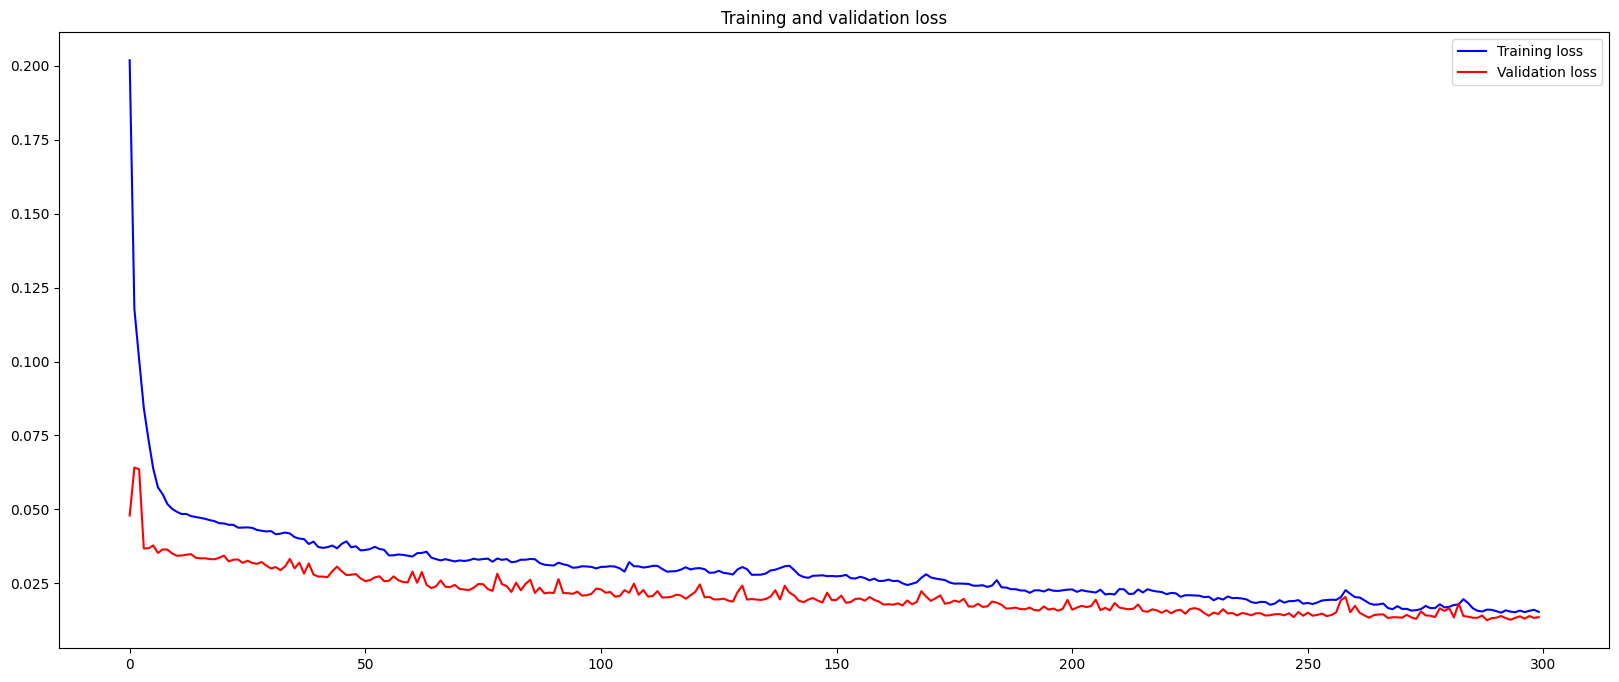

In [21]:
plot_loss(history_conv_lstm)

In [22]:
conv_lstm_model = tf.keras.models.load_model(
    "model_experiments/model_conv_lstm.keras")

model_preds = make_preds(conv_lstm_model, x_test_conv_lstm)
model_results = evaluate_preds(y_true=tf.squeeze(y_test),
                               y_pred=model_preds)

model_results

10/10 [==============================] - 2s 23ms/step


{'mae': 0.01020402, 'mse': 0.00022909019, 'r2': 0.9000036120414734}

#### Plot predictions

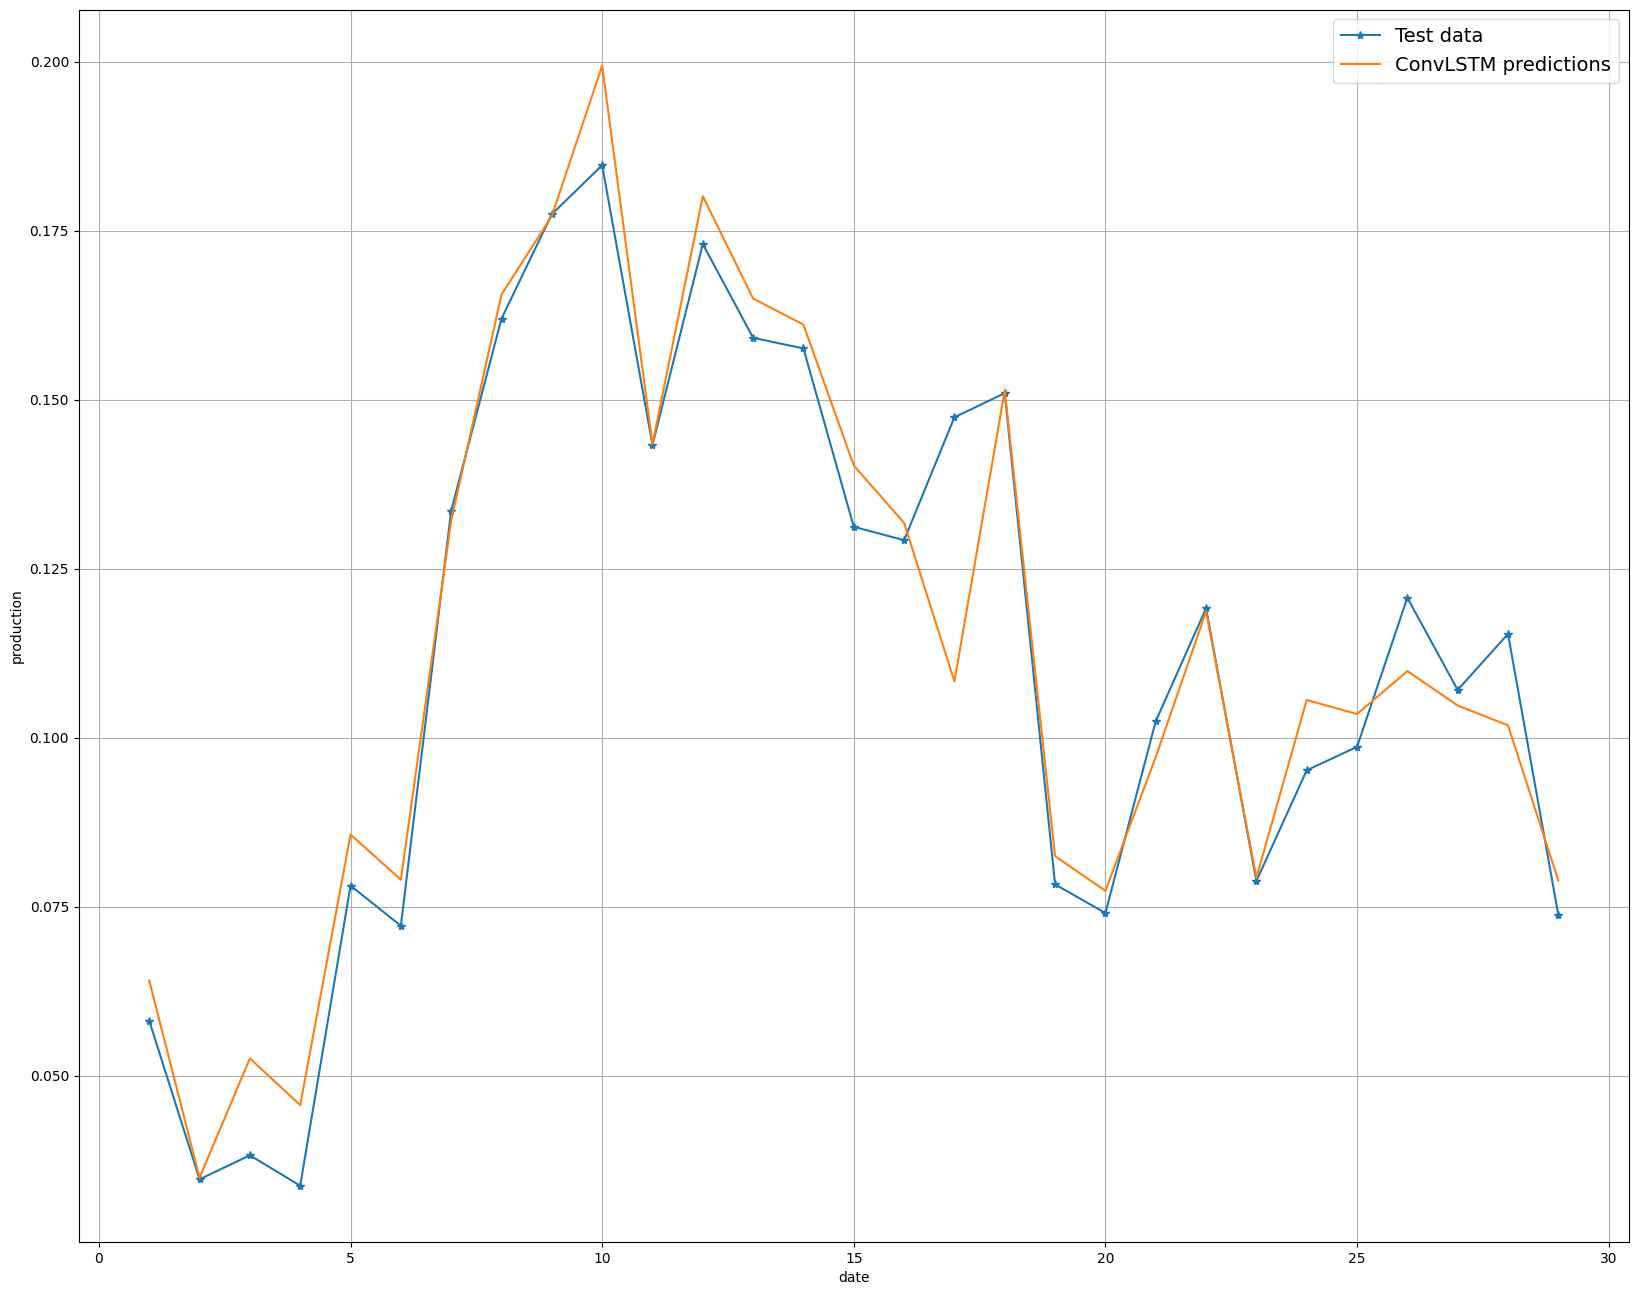

In [23]:
import numpy as np

start_offset = 1
end_offset = 30
plt.figure(figsize=(20, 16))


plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=y_test,
    start=start_offset,
    end=end_offset,
    format='-*',
    label="Test data"
)

plot_time_series(
    timesteps=np.arange(x_test.shape[0]),
    values=model_preds,
    start=start_offset,
    end=end_offset,
    format="-",
    label="ConvLSTM predictions"
)